In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset = dataset.dropna()
dataset = dataset.drop(columns = 'Unnamed: 0')
dataset = dataset.drop_duplicates()

Firstly we encode the 'track_genre' feature, using firstly a one hot encoder and the grouping by 'track_id' and summing the coulumns just generated.

In [3]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
genres = dataset.track_genre.unique().tolist()
temp = dataset[['track_id', 'track_genre']].copy()
transformed = ohe.fit_transform(temp[['track_genre']])
temp[ohe.categories_[0]] = transformed.toarray()
temp = temp.drop(columns = 'track_genre')
temp = temp.groupby('track_id').sum()
dataset = pd.merge(dataset, temp, on = 'track_id')
dataset = dataset.drop('track_genre', axis = 1)
dataset = dataset.drop_duplicates()

Then we encode the 'key' feature using one hot encoding

In [4]:
transformed = ohe.fit_transform(dataset[['key']])
dataset[ohe.get_feature_names_out()] = transformed.toarray()
dataset = dataset.drop('key', axis = 1)

And lastly we encode the 'time signature' feature using one hot encoding

In [5]:
transformed = ohe.fit_transform(dataset[['time_signature']])
dataset[ohe.get_feature_names_out()] = transformed.toarray()
dataset = dataset.drop('time_signature', axis = 1)

We notice that given a title and an artist there are a lot of copies of the same song, differenciated by album and popularity, probably due to some repack or compilation. Here an example.

In [6]:
dataset[dataset.track_name == "Frosty The Snowman"][['artists', 'album_name', 'popularity']]

,artists,album_name,popularity
11097,Ella Fitzgerald,CHRISTMAS TOP HITS 2022,0
11099,Ella Fitzgerald,Rockin' Around The Christmas Tree 2022,0
11120,Ella Fitzgerald,World's Best Christmas Playlist,0
11125,Ella Fitzgerald,Santa Claus Is Coming To Town,0
11157,Ella Fitzgerald,Christmas Songs 2022,4
11161,Ella Fitzgerald,All I Want For Christmas Is You,0
11163,Ella Fitzgerald,Christmas Classics,0
11167,Ella Fitzgerald,Rock Christmas 2022 - The Very Best Of,0
11169,Ella Fitzgerald,Holidays Are Coming,0
11177,Ella Fitzgerald,Christmas Best Hits 2022,0


This is a behavior difficult to learn by our model also given the fact the the only difference (the album feature) is a string so we decide to get rid of the 'album_name' feature keeping only the record with the higher popularity

In [7]:
idx = dataset.groupby(['track_name', 'artists'])['popularity'].transform(max) == dataset['popularity']
dataset = dataset[idx]

In [8]:
dataset = dataset.drop('album_name', axis = 1)
dataset = dataset.drop('track_id', axis = 1)
dataset = dataset.drop_duplicates()

In [9]:
dataset[dataset.track_name == "Frosty The Snowman"][['artists', 'popularity']]

,artists,popularity
11157,Ella Fitzgerald,4
74530,Cooltime Kids,0
104780,The Jackson 5,0


Now we encode the artist feature using target encoding

In [93]:
from category_encoders import TargetEncoder
te = TargetEncoder(smoothing = 1)
transformed = te.fit_transform(dataset.artists, dataset.popularity)
dataset['enc_artists'] = transformed

We could do the same with track_name, but the correlation between the two features would be so hight that in fact we would end up with a map (track>>>>popularity), this happens because the number of unique track_name is almost the same as the records and so all the information would be contained in it's encoding.
So we will not consider the 'track_name feature during the regression

In [126]:
transformed = te.fit_transform(dataset.track_name, dataset.popularity)
dataset['enc_track_name'] = transformed

In [127]:
dataset.enc_track_name.corr(dataset.popularity)

0.9509092165727047

In [128]:
print('Records:', dataset.shape[0])
print('Unique track_name:', dataset.track_name.nunique())

Records: 81514
Unique track_name: 73608


We set up the predictors array and the target value

In [129]:
predictors = dataset.columns.values.tolist()
predictors.remove('popularity')
predictors.remove('track_name')
predictors.remove('artists')
predictors.remove('enc_track_name')
target = 'popularity'

We define the functions for the regression

In [50]:
def ridge_fit(dataset, predictors_features, target_feature, alpha):
    S = dataset[predictors_features].copy()
    y = dataset[[target_feature]].copy()
    
    s_mean = S.mean()
    s_std = S.std()
    
    S = (S - s_mean) / s_std      #normalization
    S['intercept'] = 1
    S = S[['intercept'] + predictors]
    
    penalty = alpha * np.identity(S.shape[1])
    penalty[0][0] = 0
    w = np.linalg.inv(S.T @ S + penalty) @ S.T @ y
    return w, s_mean, s_std

In [31]:
def ridge_predict(dataset, predictors_features, trainset_mean, trainset_std, w):
    testset = dataset[predictors_features]
    testset = (testset - trainset_mean) / trainset_std
    testset['intercept'] = 1
    testset = testset[['intercept'] + predictors_features]
    w.index = ['intercept'] + predictors
    predictions =  testset @ w
    return predictions

To find the best value for the smoothing parameter of the target encoding we run cross validation on a dataset with the 'enc_artist' feature computed wwith different values of 'smoothing' and than we evaluate how the risk change in relation to this parameter (This process has been done on multiple sets of smoothing each time more and more little, here only the last one is shown)

In [179]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle = True, random_state=1)

In [182]:
risk = []
smooth =[]
for smooth_i in range(1,500,20):
    te = TargetEncoder(smoothing = smooth_i)
    transformed = te.fit_transform(dataset.artists, dataset.popularity)
    dataset['enc_artists'] = transformed
    loss = 0
    for train_index, test_index in kf.split(dataset):
        train, test = (dataset.iloc[train_index]), (dataset.iloc[test_index])
        w, mean, std = ridge_fit(train, predictors, target, 100)
        prediction = ridge_predict(test, predictors, mean, std, w)
        loss_i = (5/dataset.shape[0]) * sum(pow((prediction.popularity - test.popularity),2))
        loss = loss + loss_i

    cv = 1/5 * loss
    risk.append(pow(cv, 1/2))
    smooth.append(smooth_i)

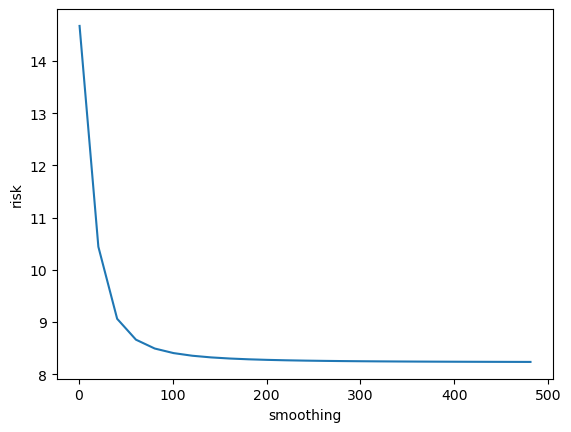

In [183]:
plt.plot(smooth, risk)
plt.xlabel('smoothing')
plt.ylabel('risk')
plt.show()

We can see that after 200 the risk become stable so we pick this value as optimal

In [169]:
te = TargetEncoder(smoothing = 200)
transformed = te.fit_transform(dataset.artists, dataset.popularity)

Now we do the same to find the optimal alpha

In [191]:
risk = []
alphas =[]
for alpha in range(1,200, 5):
    loss = 0
    for train_index, test_index in kf.split(dataset):
        train, test = (dataset.iloc[train_index]), (dataset.iloc[test_index])
        w, mean, std = ridge_fit(train, predictors, target, alpha)
        prediction = ridge_predict(test, predictors, mean, std, w)
        loss_i = (5/dataset.shape[0]) * sum(pow((prediction.popularity - test.popularity),2))
        loss = loss + loss_i

    cv = 1/5 * loss
    risk.append(pow(cv, 1/2))
    alphas.append(alpha)

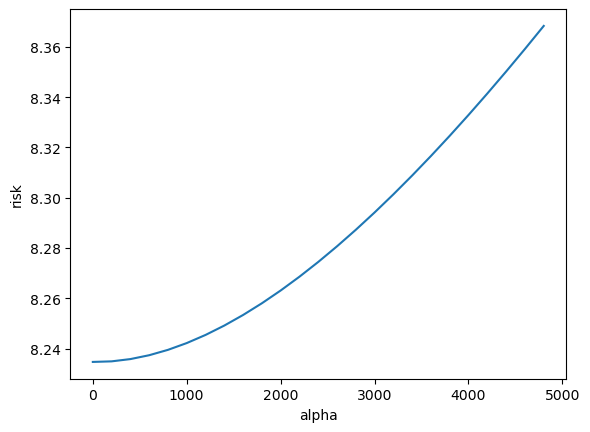

In [192]:
plt.plot(alphas, risk)
plt.xlabel('alpha')
plt.ylabel('risk')
plt.show()

As we can see the optimal value for alpha is 40.
Now using the value obtained by the anlysis for the hyperparameters (smoothing = 200 and alpha 
= 40) we use cross validation to compute the risk of our model

In [190]:
loss = 0
for train_index, test_index in kf.split(dataset):
    train, test = (dataset.iloc[train_index]), (dataset.iloc[test_index])
    w, mean, std = ridge_fit(train, predictors, target, 40)
    prediction = ridge_predict(test, predictors, mean, std, w)
    loss_i = (5/dataset.shape[0]) * sum(pow((prediction.popularity - test.popularity),2))
    loss = loss + loss_i

cv = 1/5 * loss
print(pow(cv, 1/2))
    

8.23473366583011
